In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools


from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour,create_policy_eval_video
from iarchitect.common.callbacks import output_updater,update_plotter,fig_trainer

from tf_agents.agents import DdpgAgent,DqnAgent

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

2022-03-07 16:15:58.935973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 16:15:58.936010: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
SOLUTION_NAME = "WindowEnvWhatPlantGrosReseau"

In [4]:
environment = envs.WindowEnv(16,np.fromiter(range(10),dtype=int),np.array([0,1,0,2,0,5,0,8,0,0]),render_dims=(4,4))
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

[0 0 0 8 4 0 1 1 0 3 2 4 0 8 5 0] (0,)
[6 0 0 8 4 0 1 1 0 3 2 4 0 8 5 0]
0.1 False 5 (1,)
[6 0 0 8 4 0 1 1 0 3 2 4 0 8 5 0] (1,)
[6 7 0 8 4 0 1 1 0 3 2 4 0 8 5 0]
0 False 6 (2,)
[6 7 0 8 4 0 1 1 0 3 2 4 0 8 5 0] (2,)
[6 7 1 8 4 0 1 1 0 3 2 4 0 8 5 0]
0 False 0 (5,)
[6 7 1 8 4 0 1 1 0 3 2 4 0 8 5 0] (5,)
[6 7 1 8 4 1 1 1 0 3 2 4 0 8 5 0]
0 False 0 (8,)
[6 7 1 8 4 1 1 1 0 3 2 4 0 8 5 0] (8,)
[6 7 1 8 4 1 1 1 9 3 2 4 0 8 5 0]
0 False 8 (12,)
[6 7 1 8 4 1 1 1 9 3 2 4 0 8 5 0] (12,)
[6 7 1 8 4 1 1 1 9 3 2 4 7 8 5 0]
0 False 6 (15,)
[6 7 1 8 4 1 1 1 9 3 2 4 7 8 5 0] (15,)
[6 7 1 8 4 1 1 1 9 3 2 4 7 8 5 3]
0.5 True 2 None
[ 4  6  2  9  2  9  7  7  4  4  0 10  4  2  9  8] (10,)
[ 4  6  2  9  2  9  7  7  4  4  3 10  4  2  9  8]
0.5 True 2 None
[ 0  2  9  0  0  0 10  0  2  6  9  0  4  0  5 10] (0,)
[10  2  9  0  0  0 10  0  2  6  9  0  4  0  5 10]
0 False 9 (3,)
[10  2  9  0  0  0 10  0  2  6  9  0  4  0  5 10] (3,)
[10  2  9 10  0  0 10  0  2  6  9  0  4  0  5 10]
0 False 9 (4,)
[10  2  9 10  0

In [5]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [6]:
agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network((64,64),len(environment.tuiles)),
        optimizer=Adam(learning_rate=0.0005),
        td_errors_loss_fn=common.element_wise_squared_loss,)
agent.initialize()

2022-03-07 16:16:06.593874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 16:16:06.593908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 16:16:06.593922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ALS-358): /proc/driver/nvidia/version does not exist
2022-03-07 16:16:06.594126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def plot_obs(obs,ax):
    return ax.imshow(obs,vmin=0.0,vmax=1.0)

def plot_traj(tr,ax):
    return ax.imshow(tr)

In [8]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=640,random_policy=True)

[ 2  0  3  3  6  5  0  4  5  5  3  1  9 10  8  7] (1,)
[ 2  4  3  3  6  5  0  4  5  5  3  1  9 10  8  7]
0.1 False 3 (6,)
[ 2  4  3  3  6  5  0  4  5  5  3  1  9 10  8  7] (6,)
[ 2  4  3  3  6  5  2  4  5  5  3  1  9 10  8  7]
0.5 True 1 None
[2 0 7 0 0 1 9 3 0 2 9 0 9 0 1 0] (1,)
[2 4 7 0 0 1 9 3 0 2 9 0 9 0 1 0]
0.1 False 3 (3,)
[2 4 7 0 0 1 9 3 0 2 9 0 9 0 1 0] (3,)
[2 4 7 1 0 1 9 3 0 2 9 0 9 0 1 0]
0 False 0 (4,)
[2 4 7 1 0 1 9 3 0 2 9 0 9 0 1 0] (4,)
[2 4 7 1 2 1 9 3 0 2 9 0 9 0 1 0]
0 False 1 (8,)
[2 4 7 1 2 1 9 3 0 2 9 0 9 0 1 0] (8,)
[2 4 7 1 2 1 9 3 8 2 9 0 9 0 1 0]
0.1 False 7 (11,)
[2 4 7 1 2 1 9 3 8 2 9 0 9 0 1 0] (11,)
[2 4 7 1 2 1 9 3 8 2 9 3 9 0 1 0]
0 False 2 (13,)
[2 4 7 1 2 1 9 3 8 2 9 3 9 0 1 0] (13,)
[2 4 7 1 2 1 9 3 8 2 9 3 9 6 1 0]
0.1 False 5 (15,)
[2 4 7 1 2 1 9 3 8 2 9 3 9 6 1 0] (15,)
[2 4 7 1 2 1 9 3 8 2 9 3 9 6 1 9]
0.5 True 8 None
[ 0  0  0  7  9  1  0  0  5  8  3  0  0 10  5 10] (0,)
[ 6  0  0  7  9  1  0  0  5  8  3  0  0 10  5 10]
0.1 False 5 (1,)
[ 6  0

[5 3 5 4 8 7 6 6 9 6 1 7 7 0 0 6] (13,)
[5 3 5 4 8 7 6 6 9 6 1 7 7 1 0 6]
0 False 0 (14,)
[5 3 5 4 8 7 6 6 9 6 1 7 7 1 0 6] (14,)
[5 3 5 4 8 7 6 6 9 6 1 7 7 1 5 6]
0.5 True 4 None
[9 2 6 7 4 2 8 0 0 5 9 5 8 8 0 7] (7,)
[9 2 6 7 4 2 8 3 0 5 9 5 8 8 0 7]
0 False 2 (8,)
[9 2 6 7 4 2 8 3 0 5 9 5 8 8 0 7] (8,)
[9 2 6 7 4 2 8 3 2 5 9 5 8 8 0 7]
0 False 1 (14,)
[9 2 6 7 4 2 8 3 2 5 9 5 8 8 0 7] (14,)
[9 2 6 7 4 2 8 3 2 5 9 5 8 8 1 7]
0.5 True 0 None
[0 0 4 8 0 1 2 0 0 5 1 2 0 0 0 0] (0,)
[4 0 4 8 0 1 2 0 0 5 1 2 0 0 0 0]
0.1 False 3 (1,)
[4 0 4 8 0 1 2 0 0 5 1 2 0 0 0 0] (1,)
[4 3 4 8 0 1 2 0 0 5 1 2 0 0 0 0]
0 False 2 (4,)
[4 3 4 8 0 1 2 0 0 5 1 2 0 0 0 0] (4,)
[4 3 4 8 3 1 2 0 0 5 1 2 0 0 0 0]
0 False 2 (7,)
[4 3 4 8 3 1 2 0 0 5 1 2 0 0 0 0] (7,)
[4 3 4 8 3 1 2 1 0 5 1 2 0 0 0 0]
0 False 0 (8,)
[4 3 4 8 3 1 2 1 0 5 1 2 0 0 0 0] (8,)
[4 3 4 8 3 1 2 1 1 5 1 2 0 0 0 0]
0 False 0 (12,)
[4 3 4 8 3 1 2 1 1 5 1 2 0 0 0 0] (12,)
[4 3 4 8 3 1 2 1 1 5 1 2 4 0 0 0]
0 False 3 (13,)
[4 3 4 8 3 1 2 1 1 5

[ 8  7 10  9  2  5  6  4  3 10  5 10  5  1  0  0] (14,)
[ 8  7 10  9  2  5  6  4  3 10  5 10  5  1  9  0]
0 False 8 (15,)
[ 8  7 10  9  2  5  6  4  3 10  5 10  5  1  9  0] (15,)
[ 8  7 10  9  2  5  6  4  3 10  5 10  5  1  9  6]
0.5 True 5 None
[10 10  0  4  5  3  3  6  3 10  0  4  4  2  3 10] (2,)
[10 10  3  4  5  3  3  6  3 10  0  4  4  2  3 10]
0 False 2 (10,)
[10 10  3  4  5  3  3  6  3 10  0  4  4  2  3 10] (10,)
[10 10  3  4  5  3  3  6  3 10  7  4  4  2  3 10]
0.5 True 6 None
[ 0  6  0  4  1  0  0  7  0  0 10  0  6  0  6  6] (0,)
[ 3  6  0  4  1  0  0  7  0  0 10  0  6  0  6  6]
0 False 2 (2,)
[ 3  6  0  4  1  0  0  7  0  0 10  0  6  0  6  6] (2,)
[ 3  6  5  4  1  0  0  7  0  0 10  0  6  0  6  6]
0 False 4 (5,)
[ 3  6  5  4  1  0  0  7  0  0 10  0  6  0  6  6] (5,)
[ 3  6  5  4  1  6  0  7  0  0 10  0  6  0  6  6]
0.1 False 5 (6,)
[ 3  6  5  4  1  6  0  7  0  0 10  0  6  0  6  6] (6,)
[ 3  6  5  4  1  6  2  7  0  0 10  0  6  0  6  6]
0.1 False 1 (8,)
[ 3  6  5  4  1  6  2  7  0  

[ 9  4  9  9  3  2  3  1  9  0  3  3  2  7 10  0] (9,)
[ 9  4  9  9  3  2  3  1  9  5  3  3  2  7 10  0]
0 False 4 (15,)
[ 9  4  9  9  3  2  3  1  9  5  3  3  2  7 10  0] (15,)
[ 9  4  9  9  3  2  3  1  9  5  3  3  2  7 10  6]
0.5 True 5 None
[0 2 9 2 3 2 0 2 2 0 8 6 0 2 3 5] (0,)
[9 2 9 2 3 2 0 2 2 0 8 6 0 2 3 5]
0 False 8 (6,)
[9 2 9 2 3 2 0 2 2 0 8 6 0 2 3 5] (6,)
[9 2 9 2 3 2 5 2 2 0 8 6 0 2 3 5]
0 False 4 (9,)
[9 2 9 2 3 2 5 2 2 0 8 6 0 2 3 5] (9,)
[9 2 9 2 3 2 5 2 2 6 8 6 0 2 3 5]
0.1 False 5 (12,)
[9 2 9 2 3 2 5 2 2 6 8 6 0 2 3 5] (12,)
[9 2 9 2 3 2 5 2 2 6 8 6 5 2 3 5]
0.5 True 4 None
[0 4 3 0 2 8 8 8 5 1 5 9 8 3 0 0] (0,)
[1 4 3 0 2 8 8 8 5 1 5 9 8 3 0 0]
0 False 0 (3,)
[1 4 3 0 2 8 8 8 5 1 5 9 8 3 0 0] (3,)
[1 4 3 8 2 8 8 8 5 1 5 9 8 3 0 0]
0.1 False 7 (14,)
[1 4 3 8 2 8 8 8 5 1 5 9 8 3 0 0] (14,)
[1 4 3 8 2 8 8 8 5 1 5 9 8 3 4 0]
0.1 False 3 (15,)
[1 4 3 8 2 8 8 8 5 1 5 9 8 3 4 0] (15,)
[ 1  4  3  8  2  8  8  8  5  1  5  9  8  3  4 10]
0.5 True 9 None
[2 7 0 0 2 0 2 0 0 0 0 

[ 3  4  8  3  1 10  3  1  0  3  0  0  4  3 10  8] (8,)
[ 3  4  8  3  1 10  3  1  6  3  0  0  4  3 10  8]
0.1 False 5 (10,)
[ 3  4  8  3  1 10  3  1  6  3  0  0  4  3 10  8] (10,)
[ 3  4  8  3  1 10  3  1  6  3  1  0  4  3 10  8]
0 False 0 (11,)
[ 3  4  8  3  1 10  3  1  6  3  1  0  4  3 10  8] (11,)
[ 3  4  8  3  1 10  3  1  6  3  1  8  4  3 10  8]
0.5 True 7 None
[10  5  6  0  2  2  3  3  9  2  7  1  6 10  5  1] (3,)
[10  5  6  8  2  2  3  3  9  2  7  1  6 10  5  1]
0.5 True 7 None
[ 6  0  8  8  8  0  5  0  3  0  3  0  5  8  0 10] (1,)
[ 6  3  8  8  8  0  5  0  3  0  3  0  5  8  0 10]
0 False 2 (5,)
[ 6  3  8  8  8  0  5  0  3  0  3  0  5  8  0 10] (5,)
[ 6  3  8  8  8  4  5  0  3  0  3  0  5  8  0 10]
0.1 False 3 (7,)
[ 6  3  8  8  8  4  5  0  3  0  3  0  5  8  0 10] (7,)
[ 6  3  8  8  8  4  5  2  3  0  3  0  5  8  0 10]
0.1 False 1 (9,)
[ 6  3  8  8  8  4  5  2  3  0  3  0  5  8  0 10] (9,)
[ 6  3  8  8  8  4  5  2  3  3  3  0  5  8  0 10]
0 False 2 (11,)
[ 6  3  8  8  8  4  5  2  3

[0 4 7 0 8 0 0 3 5 0 0 0 8 0 0 0] (0,)
[10  4  7  0  8  0  0  3  5  0  0  0  8  0  0  0]
0 False 9 (3,)
[10  4  7  0  8  0  0  3  5  0  0  0  8  0  0  0] (3,)
[10  4  7  7  8  0  0  3  5  0  0  0  8  0  0  0]
0 False 6 (5,)
[10  4  7  7  8  0  0  3  5  0  0  0  8  0  0  0] (5,)
[10  4  7  7  8  9  0  3  5  0  0  0  8  0  0  0]
0 False 8 (6,)
[10  4  7  7  8  9  0  3  5  0  0  0  8  0  0  0] (6,)
[10  4  7  7  8  9  5  3  5  0  0  0  8  0  0  0]
0 False 4 (9,)
[10  4  7  7  8  9  5  3  5  0  0  0  8  0  0  0] (9,)
[10  4  7  7  8  9  5  3  5  5  0  0  8  0  0  0]
0 False 4 (10,)
[10  4  7  7  8  9  5  3  5  5  0  0  8  0  0  0] (10,)
[10  4  7  7  8  9  5  3  5  5 10  0  8  0  0  0]
0 False 9 (11,)
[10  4  7  7  8  9  5  3  5  5 10  0  8  0  0  0] (11,)
[10  4  7  7  8  9  5  3  5  5 10  4  8  0  0  0]
0.1 False 3 (13,)
[10  4  7  7  8  9  5  3  5  5 10  4  8  0  0  0] (13,)
[10  4  7  7  8  9  5  3  5  5 10  4  8 10  0  0]
0 False 9 (14,)
[10  4  7  7  8  9  5  3  5  5 10  4  8 10  0  

[ 5  4  0  5  2  2  7  9  3  7  0  7  0  7 10  6] (2,)
[ 5  4  1  5  2  2  7  9  3  7  0  7  0  7 10  6]
0 False 0 (10,)
[ 5  4  1  5  2  2  7  9  3  7  0  7  0  7 10  6] (10,)
[ 5  4  1  5  2  2  7  9  3  7  7  7  0  7 10  6]
0 False 6 (12,)
[ 5  4  1  5  2  2  7  9  3  7  7  7  0  7 10  6] (12,)
[ 5  4  1  5  2  2  7  9  3  7  7  7 10  7 10  6]
0.5 True 9 None
[ 0  0  9 10  0  0  0  0  1  0  0  0  0  8  0  0] (0,)
[ 6  0  9 10  0  0  0  0  1  0  0  0  0  8  0  0]
0.1 False 5 (1,)
[ 6  0  9 10  0  0  0  0  1  0  0  0  0  8  0  0] (1,)
[ 6  8  9 10  0  0  0  0  1  0  0  0  0  8  0  0]
0.1 False 7 (4,)
[ 6  8  9 10  0  0  0  0  1  0  0  0  0  8  0  0] (4,)
[ 6  8  9 10  4  0  0  0  1  0  0  0  0  8  0  0]
0.1 False 3 (5,)
[ 6  8  9 10  4  0  0  0  1  0  0  0  0  8  0  0] (5,)
[ 6  8  9 10  4  5  0  0  1  0  0  0  0  8  0  0]
0 False 4 (6,)
[ 6  8  9 10  4  5  0  0  1  0  0  0  0  8  0  0] (6,)
[ 6  8  9 10  4  5  3  0  1  0  0  0  0  8  0  0]
0 False 2 (7,)
[ 6  8  9 10  4  5  3  0  1  

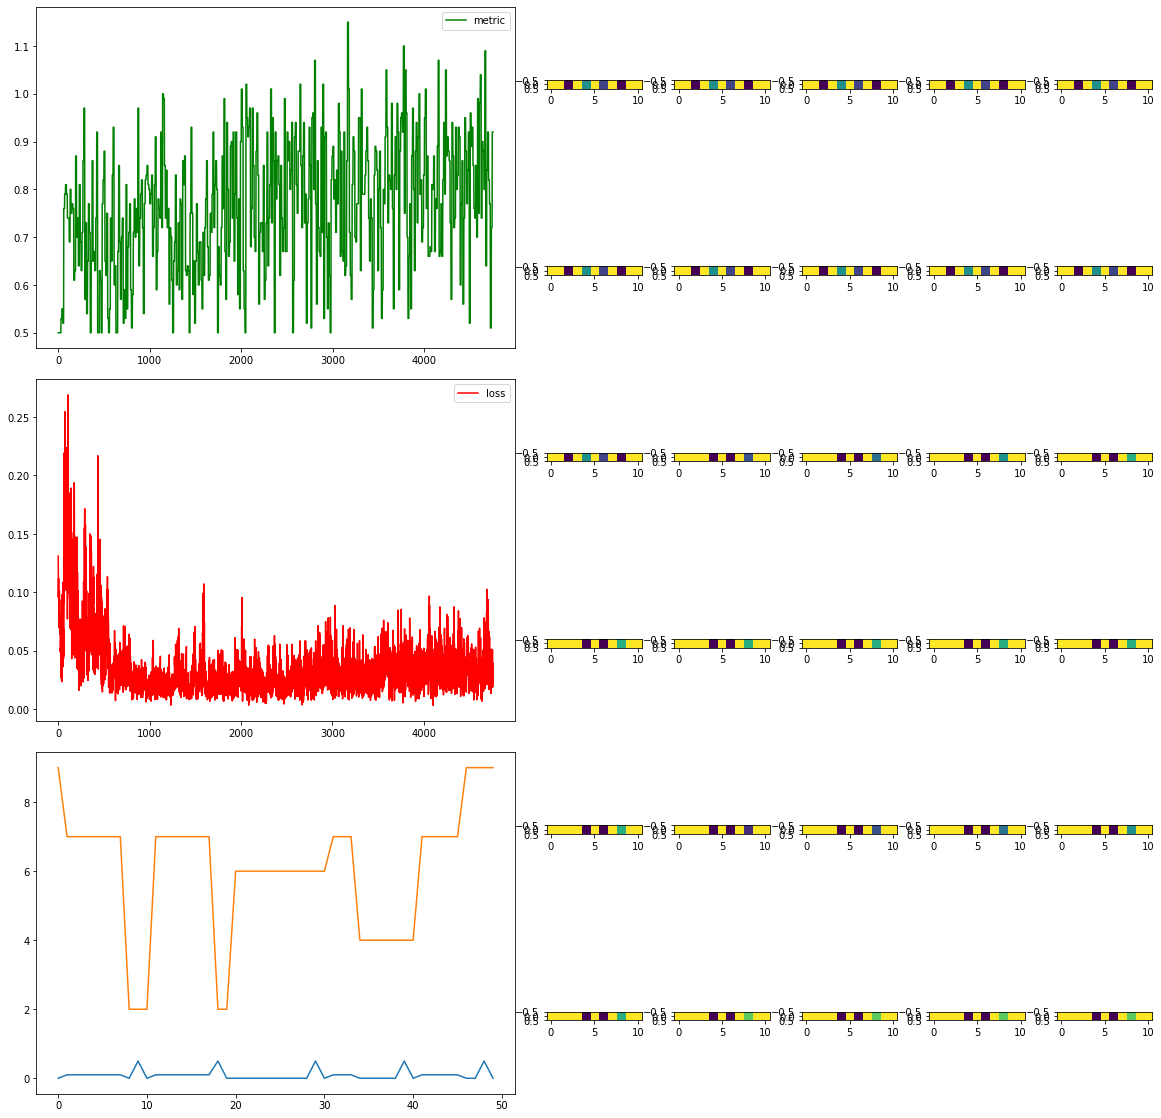

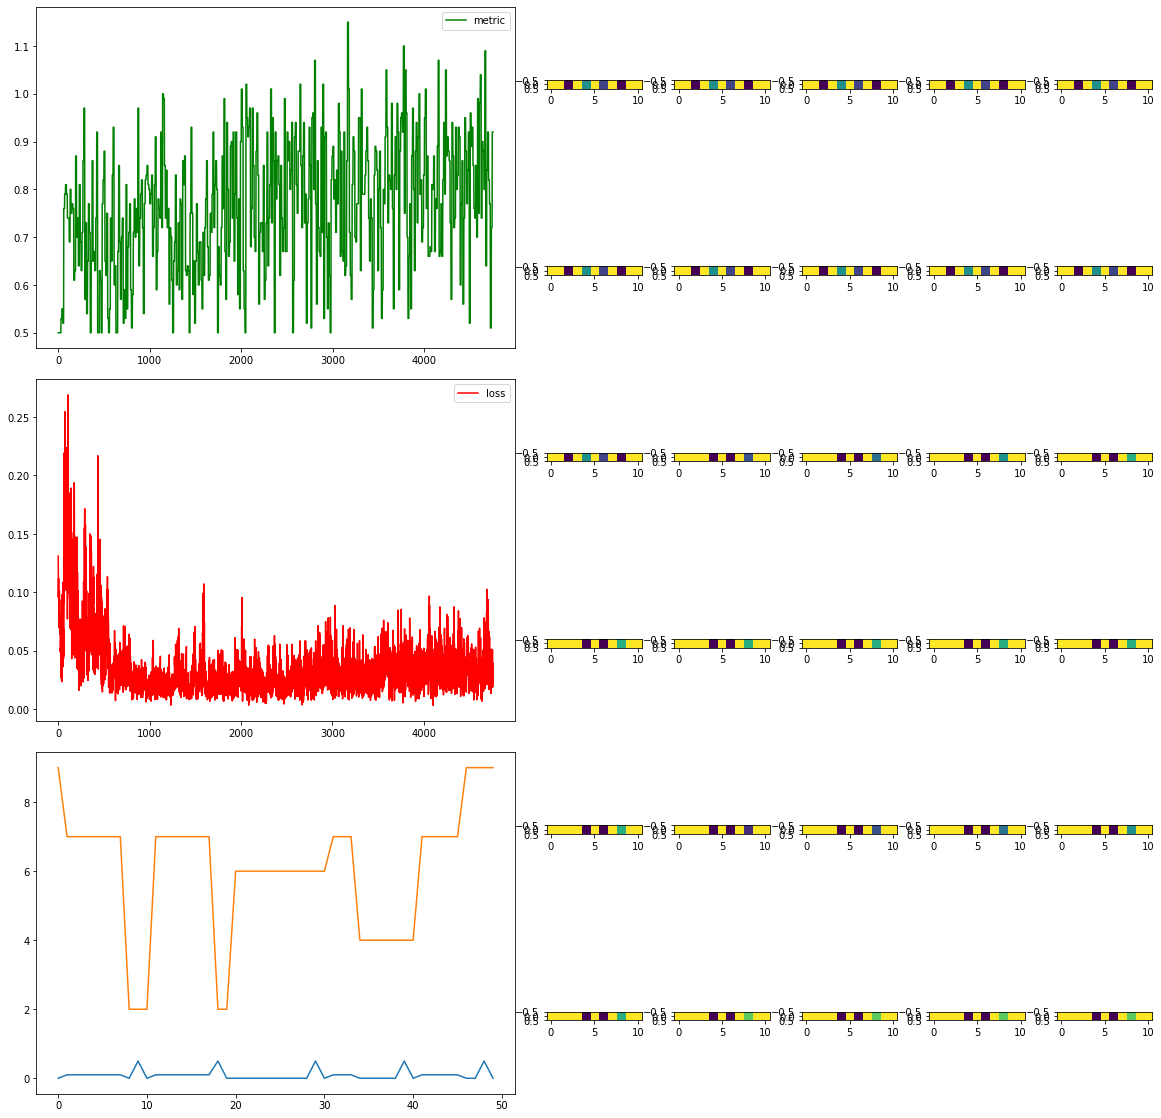

In [9]:
fig_tr = fig_trainer(6,6,figsize=(20,20))
callbacks = [update_plotter(fig_tr,plot_obs),
             output_updater(fig_tr,clear_output=True)
             ]

trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

In [11]:
fig_tr.savefig(SOLUTION_NAME+".png")

In [ ]:
trainer.tf_env.reset()
fig,ax = plt.subplots()
fig2,axes_ = plt.subplots(5,5)
trainer.evaluate_agent(50)
obs=trainer.observer.observations()[-25:]
trainer.observer.plot_reward(ax=ax,slice_=slice(-25,None,None))
for o,ax_ in zip(obs,fig2.axes):
    res = plot_obs(o,ax_)
res

In [99]:
create_policy_eval_video(train_env,environment,trainer.agent.policy,SOLUTION_NAME,num_episodes=10,fps=5)

In [100]:
create_policy_eval_video(train_env,environment,random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec()),SOLUTION_NAME + "_random",num_episodes=10,fps=5)

(288, 432, 4)

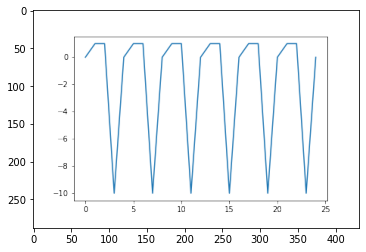

In [97]:
import io
io_buf = io.BytesIO()
fig.savefig(io_buf, format='raw', dpi=fig.dpi)
io_buf.seek(0)
img_arr = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape((int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
io_buf.close()
plt.imshow(img_arr)
img_arr.shape

In [82]:
newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1)

In [83]:
newshape

(288, 432, -1)

In [94]:
497664/288/432

4.0

In [85]:
img_arr.shape

(8640000,)

In [87]:
fig.bbox.bounds

(0.0, 0.0, 432.0, 288.0)

In [92]:
fig.dpi

72.0